# CSCI 4022 Final Project Data Clustering



In [2]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
import plotly.express as px
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import networkx as nx

In [3]:
# load data
dfTeams = pd.read_csv('teams.csv')
dfTeamBox = pd.read_csv('team_box_scores_clean.csv')
dfTeamStatsPCA = pd.read_csv('team_stats_pca.csv')
dfTeamStats = pd.read_csv('team_stats.csv')
index_to_team_id = {i: dfTeamStats['team_id'][i] for i in range(len(dfTeamStats))}
dfTeamStats.drop(['team_id'], axis=1, inplace=True)
dfTeamStatsIn = dfTeamStatsPCA.copy()

## Team Clustering

Here I will use kmeans clustering to cluster the teams. I will use sklearns kmeans function along with the kmeans code we wrote in class this semester. 

I will use sklearn's KMeans algorithm in order to kind the optimal k as it runs faster than the KMeans code from class. Once I have the optimal k I will cluster the games using both SKLearn and the KMeans algorithm from class and compare the results.

### Helper functions

In [4]:
randomState=0

# use a heatmap to display the correlation between clusters and features
def graphClusterStats(df, cluster_col):
    dfAgg = df.groupby(cluster_col).mean()
    plt.figure(figsize=(12, 8))
    sns.heatmap(dfAgg.T, cmap='coolwarm', annot=True, fmt=".1f", cbar=True)
    plt.xlabel('Cluster')
    plt.ylabel('Stat')
    plt.title('Cluster Statistics Heatmap')
    plt.show()
    return dfAgg

# used to generate colors for 
def generate_n_colors(n):
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

# chart the first 50 teams associated with each cluster
def chartTeamClusters(teamClusterDict):
    # plot list of team names color coordinated by conference
    plt.figure(figsize=(16, 12)) 
    plt.axis('off') 
    for i, (cluster, teams_and_confs) in enumerate(teamClusterDict.items()):
        plt.text(0.5 + i/2 + 0.25, 0.9, f'Cluster {cluster}', ha='center', va='center', fontsize=50, fontweight='bold')
        for j, team_and_conf in enumerate(teams_and_confs):
            if j < 50:
                team = team_and_conf[0]
                conf = team_and_conf[1]
                plt.text(0.5 + i/2 + 0.25, 0.8 - j * 0.065, team, ha='center', va='center', color=conf_to_color[conf], fontsize=35) 
    
    # create a legend for the conferences
    colors = []
    conferences = []
    for conf, color in conf_to_color.items():
        colors.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=30))
        conferences.append(conf)
    plt.legend(colors, conferences, loc='upper left', title='Conference', fontsize=45, title_fontsize=35)
    
    plt.show()
    
# find team names and conferences from ids
def findTeamsFromClusters(df, cluster_col):
    # find team ids for teams in each cluster
    cluster_team_ids = {cluster_id: df[df[cluster_col] == cluster_id].index.tolist() for cluster_id in range(k)}

    # convert ids to team names
    cluster_teams = {}
    for cluster, indexes in cluster_team_ids.items():
        team_names_and_conferences = []
        for index in indexes:
            row = dfTeams[dfTeams['id'] == index_to_team_id[index]]
            team_names_and_conferences.append([row['market'].values[0], row['conf_alias'].values[0]])
        cluster_teams[cluster] = sorted(team_names_and_conferences, key=lambda x: x[1])
    return cluster_teams

# convert conference alias to color
confs = dfTeams['conf_alias'].unique()
colors = generate_n_colors(len(confs))
conf_to_color = {confs[i]: colors[i] for i in range(len(confs))}

# Euclidean distance
def distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

# class kmeans algo
def kmeans_class(df, k=4, verbose=False, tol=0.05, centroids=[]):  
    # choose k random rows to be the centroids without replacement
    if len(centroids) == 0:
        centroids = df.sample(k, replace=False, random_state=randomState).values.astype(float)
    # initialize cluster assignments
    clusters = np.array([-1]*len(df))
    # set previous reconstruction error to 0
    prev_r_error = 0
    # set reconstruction error to infinity
    r_error = float('inf')
    # number of iterations
    num_iter = 0
    while(abs(prev_r_error - r_error) > tol and num_iter < 20):
        num_iter += 1
        # set previous reconstruction error to reconstruction error
        prev_r_error = r_error
        # reset reconstruction error
        r_error = 0
                        
        # assign point to cluster
        for i in range(len(clusters)):
            dists = [distance(df.loc[i], cent) for cent in centroids]
            min_dist = min(dists)
            assignment = dists.index(min_dist)
            clusters[i] = assignment
            # add dist to reconstruction error
            r_error += min_dist**2

        # update centroids
        for j in range(k):
            centroids[j] = df[clusters==j].mean().values
        if verbose:
            print(abs(prev_r_error - r_error))
    
    if verbose:
        print(f'Done at iteration {num_iter} with change of {abs(prev_r_error - r_error)}')
    return clusters, r_error / len(clusters)

### Finding the optimal k

In [5]:
# use sklearn kmeans algorithm, run with k values ranging from 2-50
errors_for_ks = []
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    errors_for_ks.append([k, kmeans.fit(dfTeamStatsIn).inertia_])

Text(0.5, 1.0, 'k vs mse')

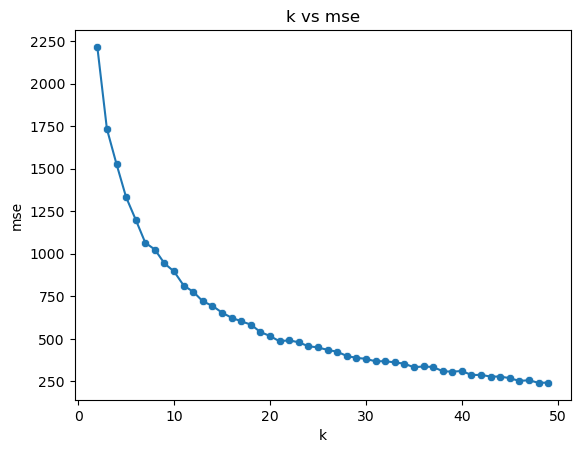

In [6]:
# elbow plot for different k values
kdf = pd.DataFrame(errors_for_ks, columns=['k', 'mse'])
sns.lineplot(kdf, x='k', y='mse')
sns.scatterplot(kdf, x='k', y='mse')
plt.title('k vs mse')

There seems to be an elbow in the plot around k=6, 7, and 8. Choosing k=6 to have less clusters for interpretability.

### SKLearn KMeans Clustering

In [7]:
k = 6
# generate centroids to start kmeans with, will use same centroids for sklearn and our class code
centroids = dfTeamStatsIn.sample(k, replace=False, random_state=randomState).values.astype(float)

In [8]:
# cluster using sklearn kmeans
kmeans = KMeans(n_clusters=k, init=centroids, n_init=1, random_state=randomState)
clusters = kmeans.fit_predict(dfTeamStatsIn)
error = kmeans.inertia_

In [9]:
# store the results of the clustering alongside the PCA components
results = dfTeamStatsPCA.copy()
results['cluster'] = clusters

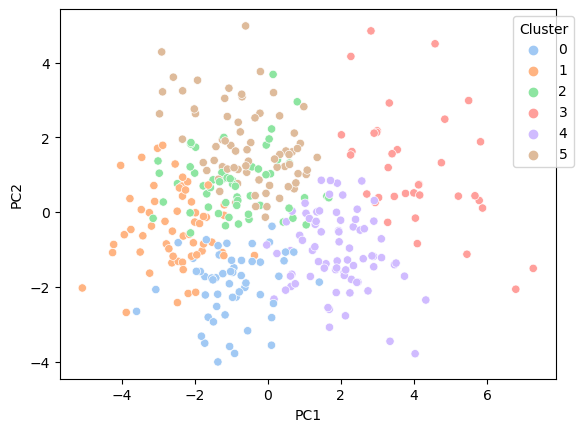

In [10]:
# plot the clusters vs PC1 and PC2
ax = sns.scatterplot(data=results, x='PC1',y='PC2',hue='cluster', palette="pastel")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.show()

From this plot, you can see good separation between the red, purple, blue clusters. The orange, brown, and green clusters seem to be mixed.

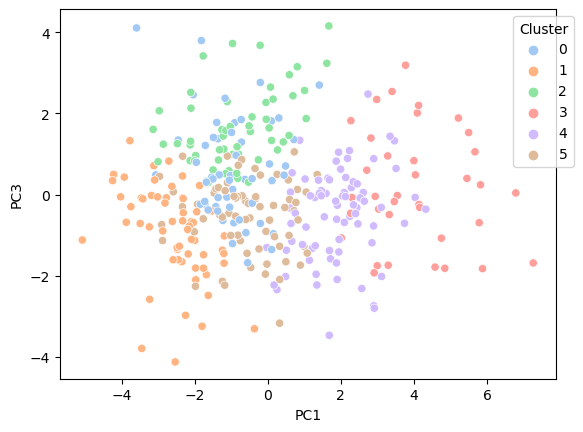

In [11]:
# plot the clusters
ax = sns.scatterplot(data=results, x='PC1',y='PC3',hue='cluster', palette="pastel")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.show()

From this plot you can see the separation between the green and brown clusters but orange is still mixed.

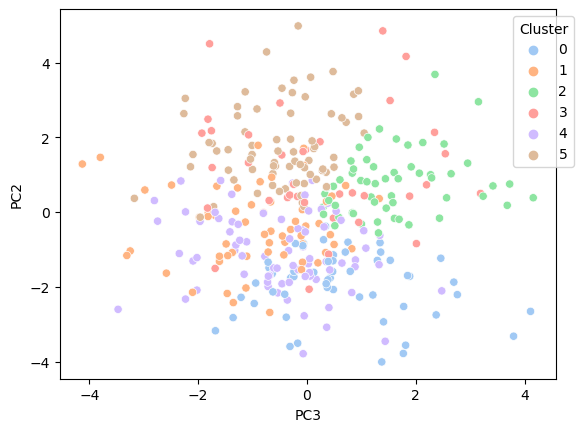

In [12]:
# plot the clusters
ax = sns.scatterplot(data=results, x='PC3',y='PC2',hue='cluster', palette="pastel")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.show()

This plot shows the difference between brown and orange.

Overall, the above plots show that clusters 3, 4, and 0 (red, purple, and blue) are well separated by PC1 and PC2. Clusters 5 and 2 (brown and green) are well separated by PC3. Finally, clusters 1 and 5 (blue and brown) are well separated by PC2.

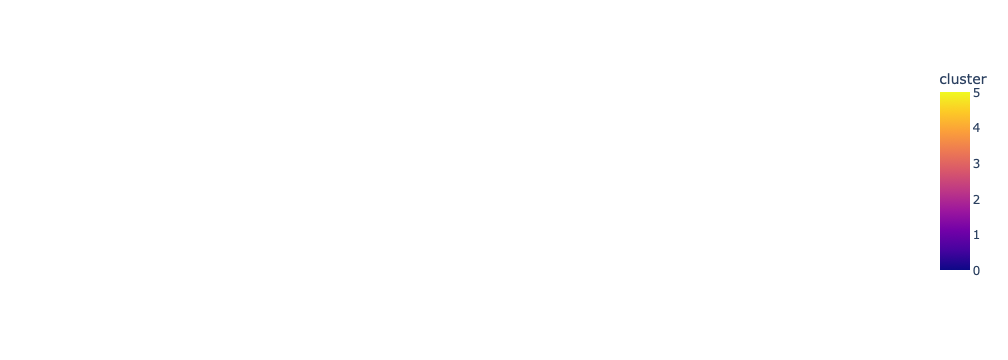

In [13]:
# show 3d plot of clusters
fig = px.scatter_3d(results, x='PC1', y='PC2', z='PC3', color='cluster')
fig.update_traces(marker_size = 3)
fig.show()

In [14]:
dfTeamStats['cluster'] = clusters

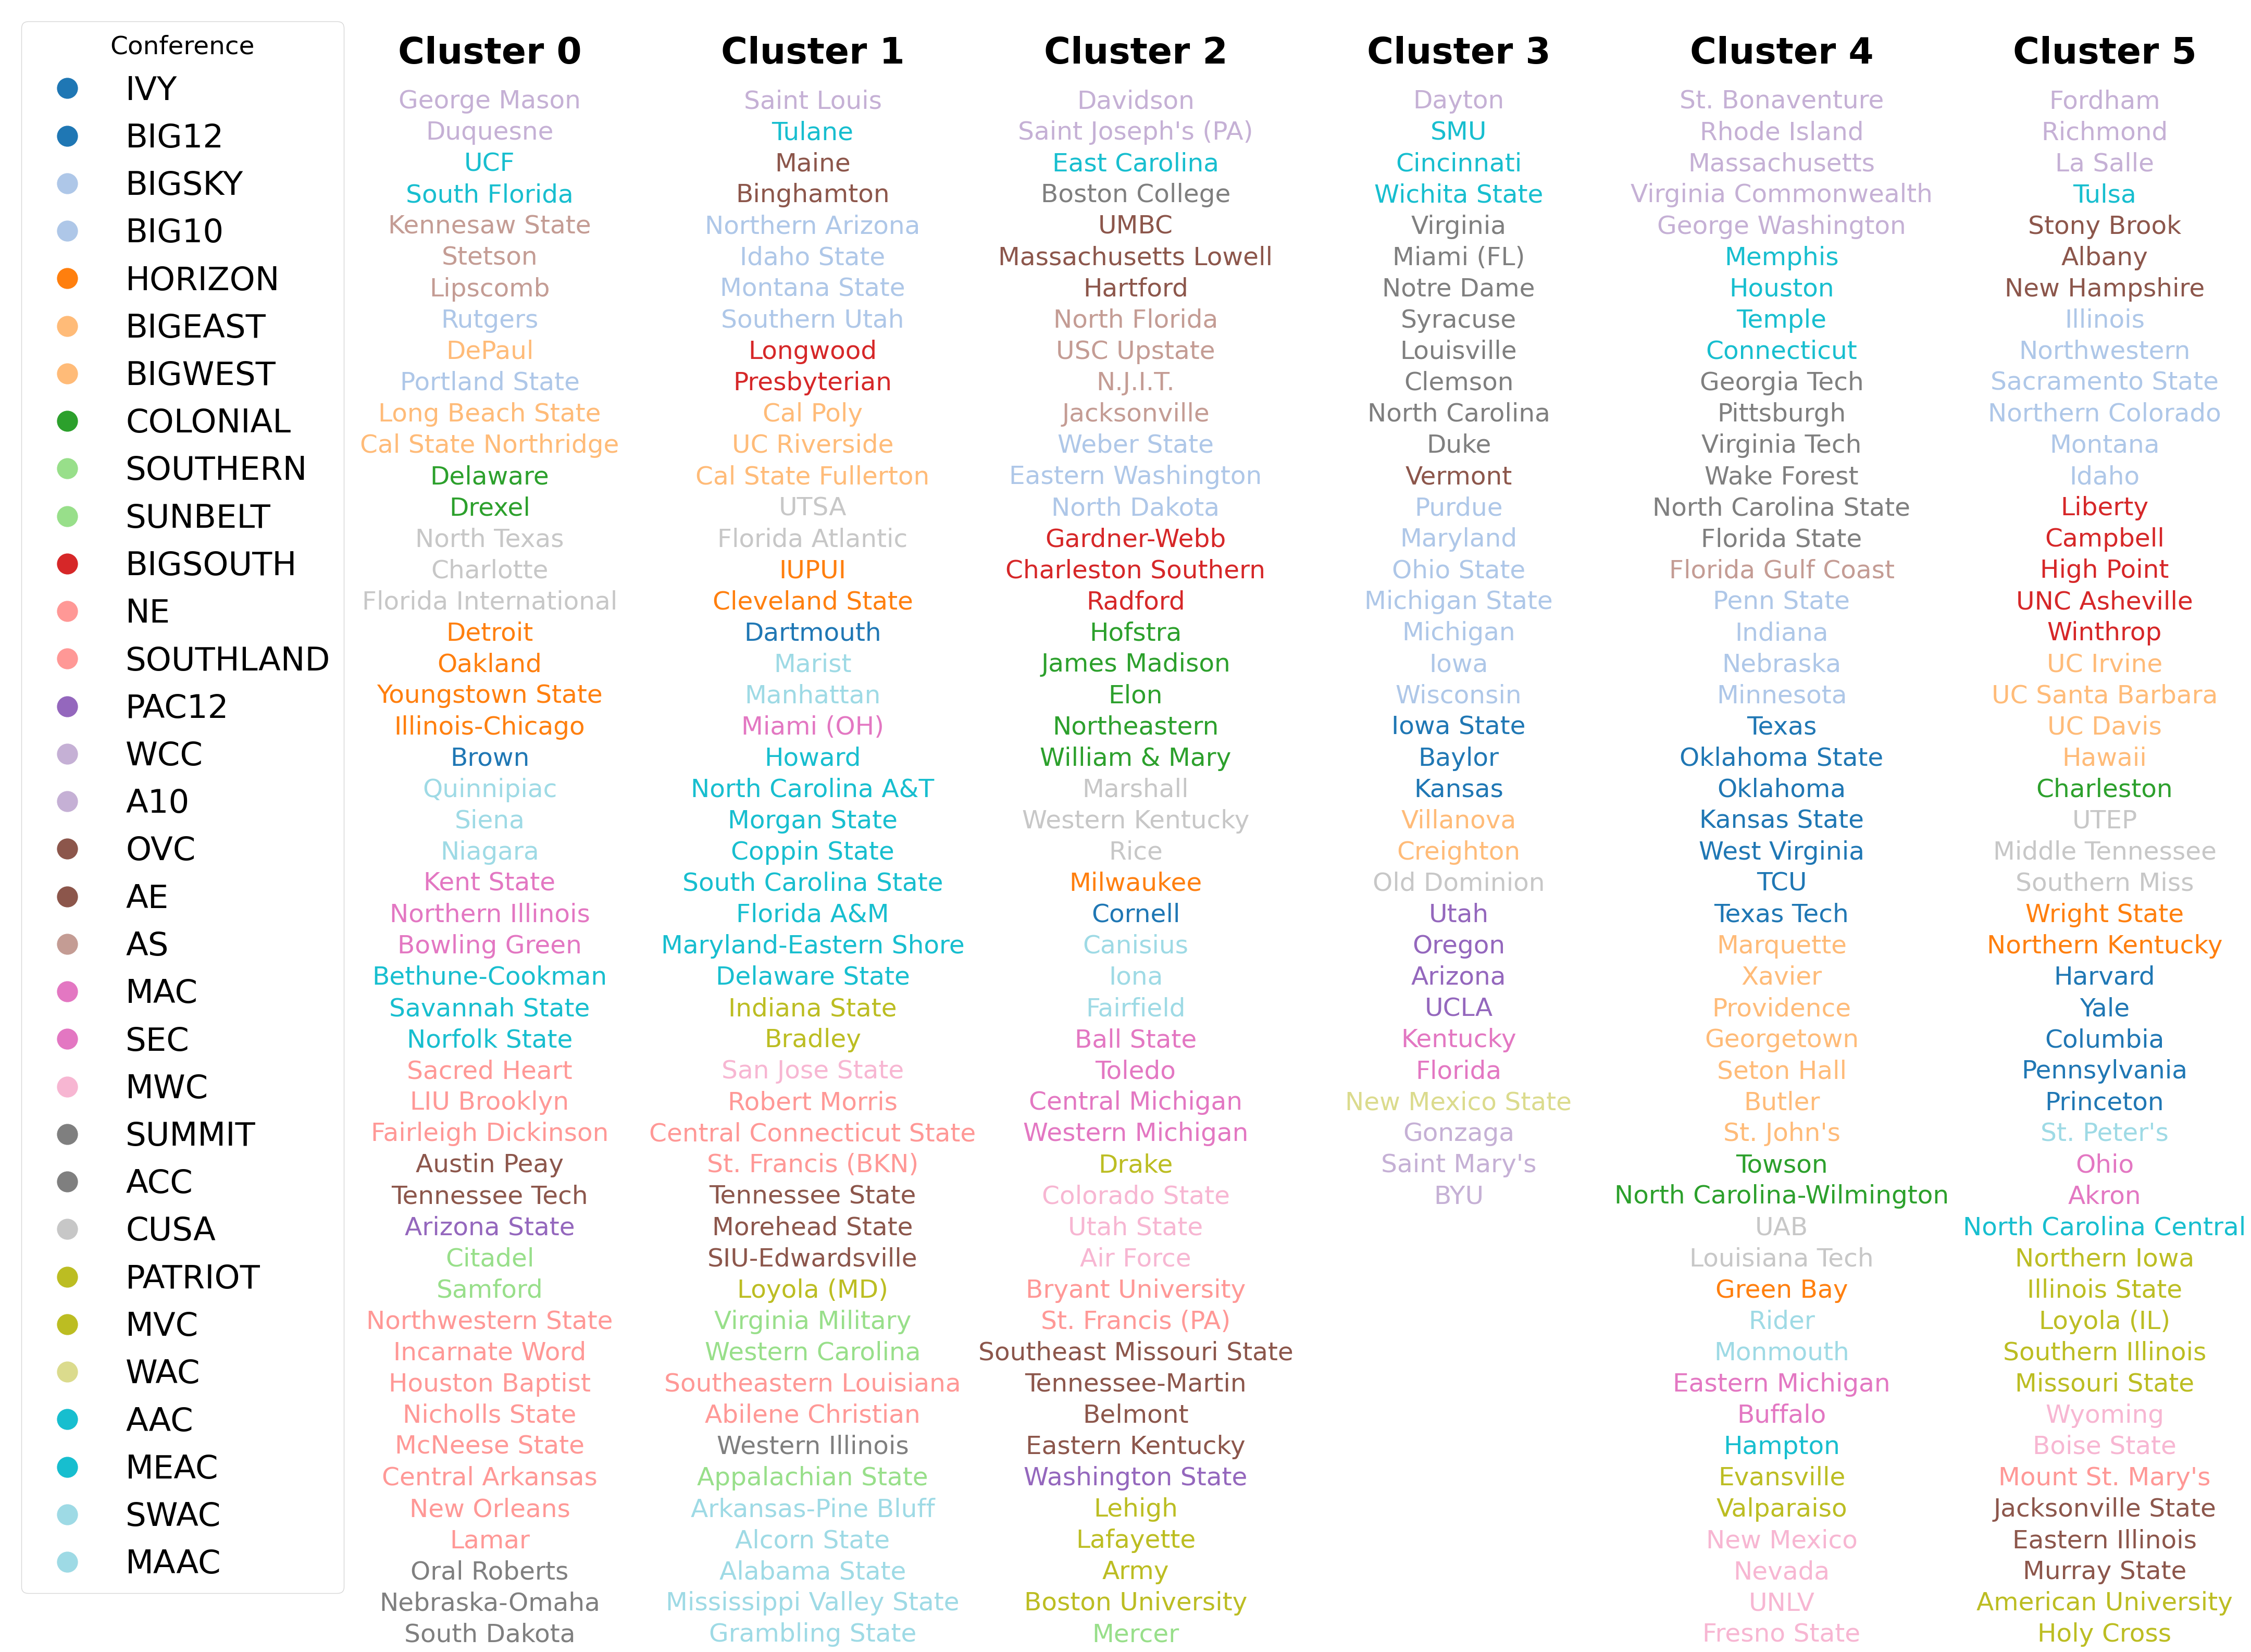

In [15]:
# print the first 50 teams in each cluster color coded by their conference
cluster_teams = findTeamsFromClusters(dfTeamStats, 'cluster')
chartTeamClusters({key: value for key, value in cluster_teams.items() if key < 7})

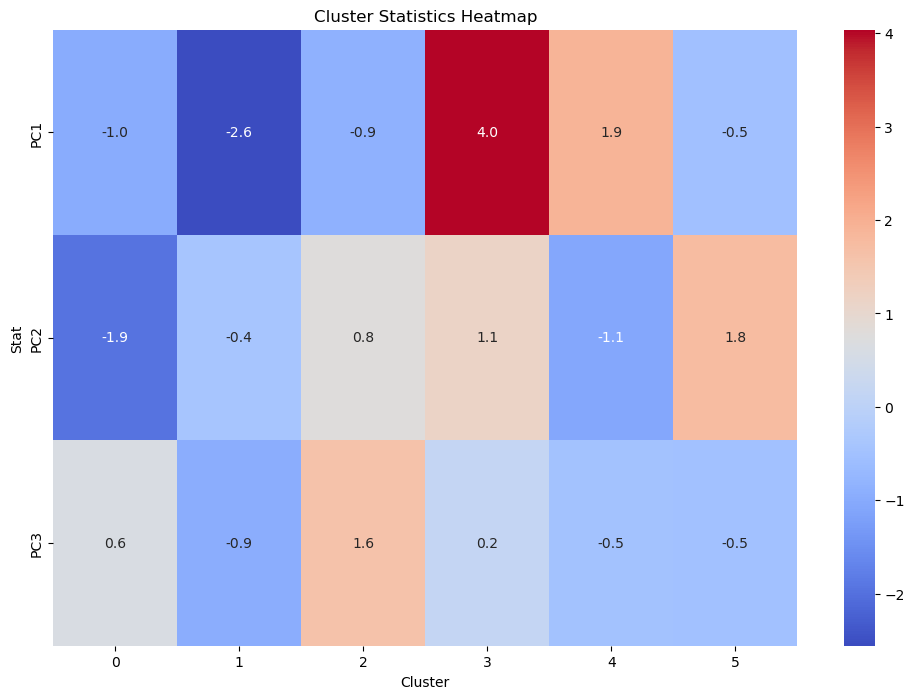

In [16]:
# heat map to show the average values for different statistics for each cluster
dfAgg = graphClusterStats(results, 'cluster')

In [17]:
# get ids of teams in each cluster
cluster_team_ids = {cluster_id: list(map(lambda x: index_to_team_id[x], dfTeamStats[dfTeamStats['cluster'] == cluster_id].index.tolist())) for cluster_id in range(k)}

In [18]:
# get home win percentages of every cluster against every other cluster
cluster_win_comparison = np.zeros((k, k))
for home_cluster in range(k):
    for away_cluster in range(k):
        if home_cluster == away_cluster:
            cluster_win_comparison[home_cluster][away_cluster] = 0
        else:
            allGames = dfTeamBox[(dfTeamBox['home_team'] == True) & (dfTeamBox['team_id'].isin(cluster_team_ids[home_cluster])) & (dfTeamBox['opp_id'].isin(cluster_team_ids[away_cluster]))]
            winningGames = allGames[allGames['win'] == True]
            cluster_win_comparison[home_cluster][away_cluster] = len(winningGames) / len(allGames)

In [19]:
# get the away win percentages of every cluster against every other cluster
cluster_win_comparison_away = np.zeros((k, k))
for away_cluster in range(k):
    for home_cluster in range(k):
        if home_cluster == away_cluster:
            cluster_win_comparison_away[away_cluster][home_cluster] = 0
        else:
            allGames = dfTeamBox[(dfTeamBox['home_team'] == False) & (dfTeamBox['team_id'].isin(cluster_team_ids[away_cluster])) & (dfTeamBox['opp_id'].isin(cluster_team_ids[home_cluster]))]
            winningGames = allGames[allGames['win'] == True]
            cluster_win_comparison_away[away_cluster][home_cluster] = len(winningGames) / len(allGames)

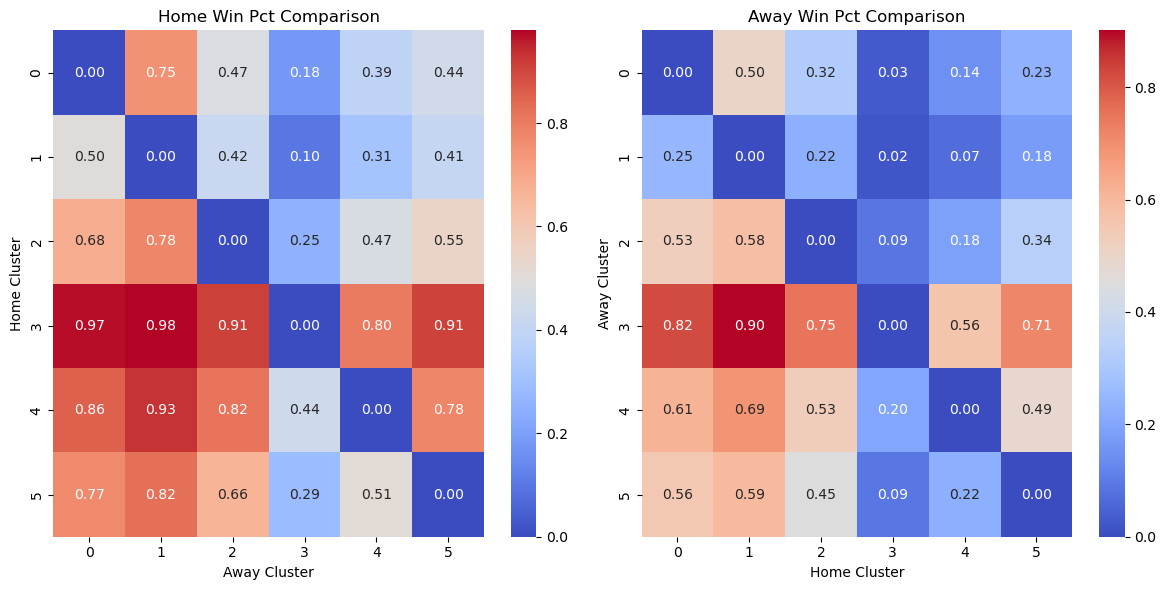

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(cluster_win_comparison, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[0])
axs[0].set_xlabel('Away Cluster')
axs[0].set_ylabel('Home Cluster')
axs[0].set_title('Home Win Pct Comparison')

# Plot the second heatmap
sns.heatmap(cluster_win_comparison_away, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[1])
axs[1].set_xlabel('Home Cluster')
axs[1].set_ylabel('Away Cluster')
axs[1].set_title('Away Win Pct Comparison')

plt.tight_layout()
plt.show()

### Class KMeans Clustering

In [33]:
# use class kmeans algo to cluster
class_clusters, class_error=kmeans_class(dfTeamStatsIn, k=k, verbose=True, tol=0.0001)
print('Final mean error class: ', class_error)
print('Final mean error sklearn: ', error)

inf
524.1092119160439
76.11499225841703
33.24760896503858
15.200323299354068
12.681289939642056
10.818826319441541
10.169124877086006
11.349308447523072
4.886570085549465
5.266978257918481
11.192359146603621
16.357072309452406
9.311058422421638
4.045245138619748
2.3007358737413597
2.697201083434038
2.0909747837617942
0.7060643165712008
0.890130309682263
Done at iteration 20 with change of 0.890130309682263
Final mean error class:  3.3602701726878212
Final mean error sklearn:  1176.9796467521114


In [34]:
# get the results
results1 = dfTeamStatsPCA.copy()
results1['cluster'] = class_clusters

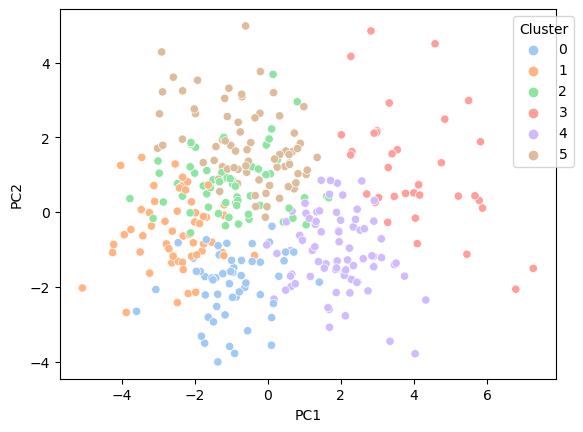

In [35]:
# plot results
ax = sns.scatterplot(data=results1, x='PC1',y='PC2',hue='cluster', palette="pastel")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.show()

In [36]:
dfTeamStats['class_cluster'] = class_clusters

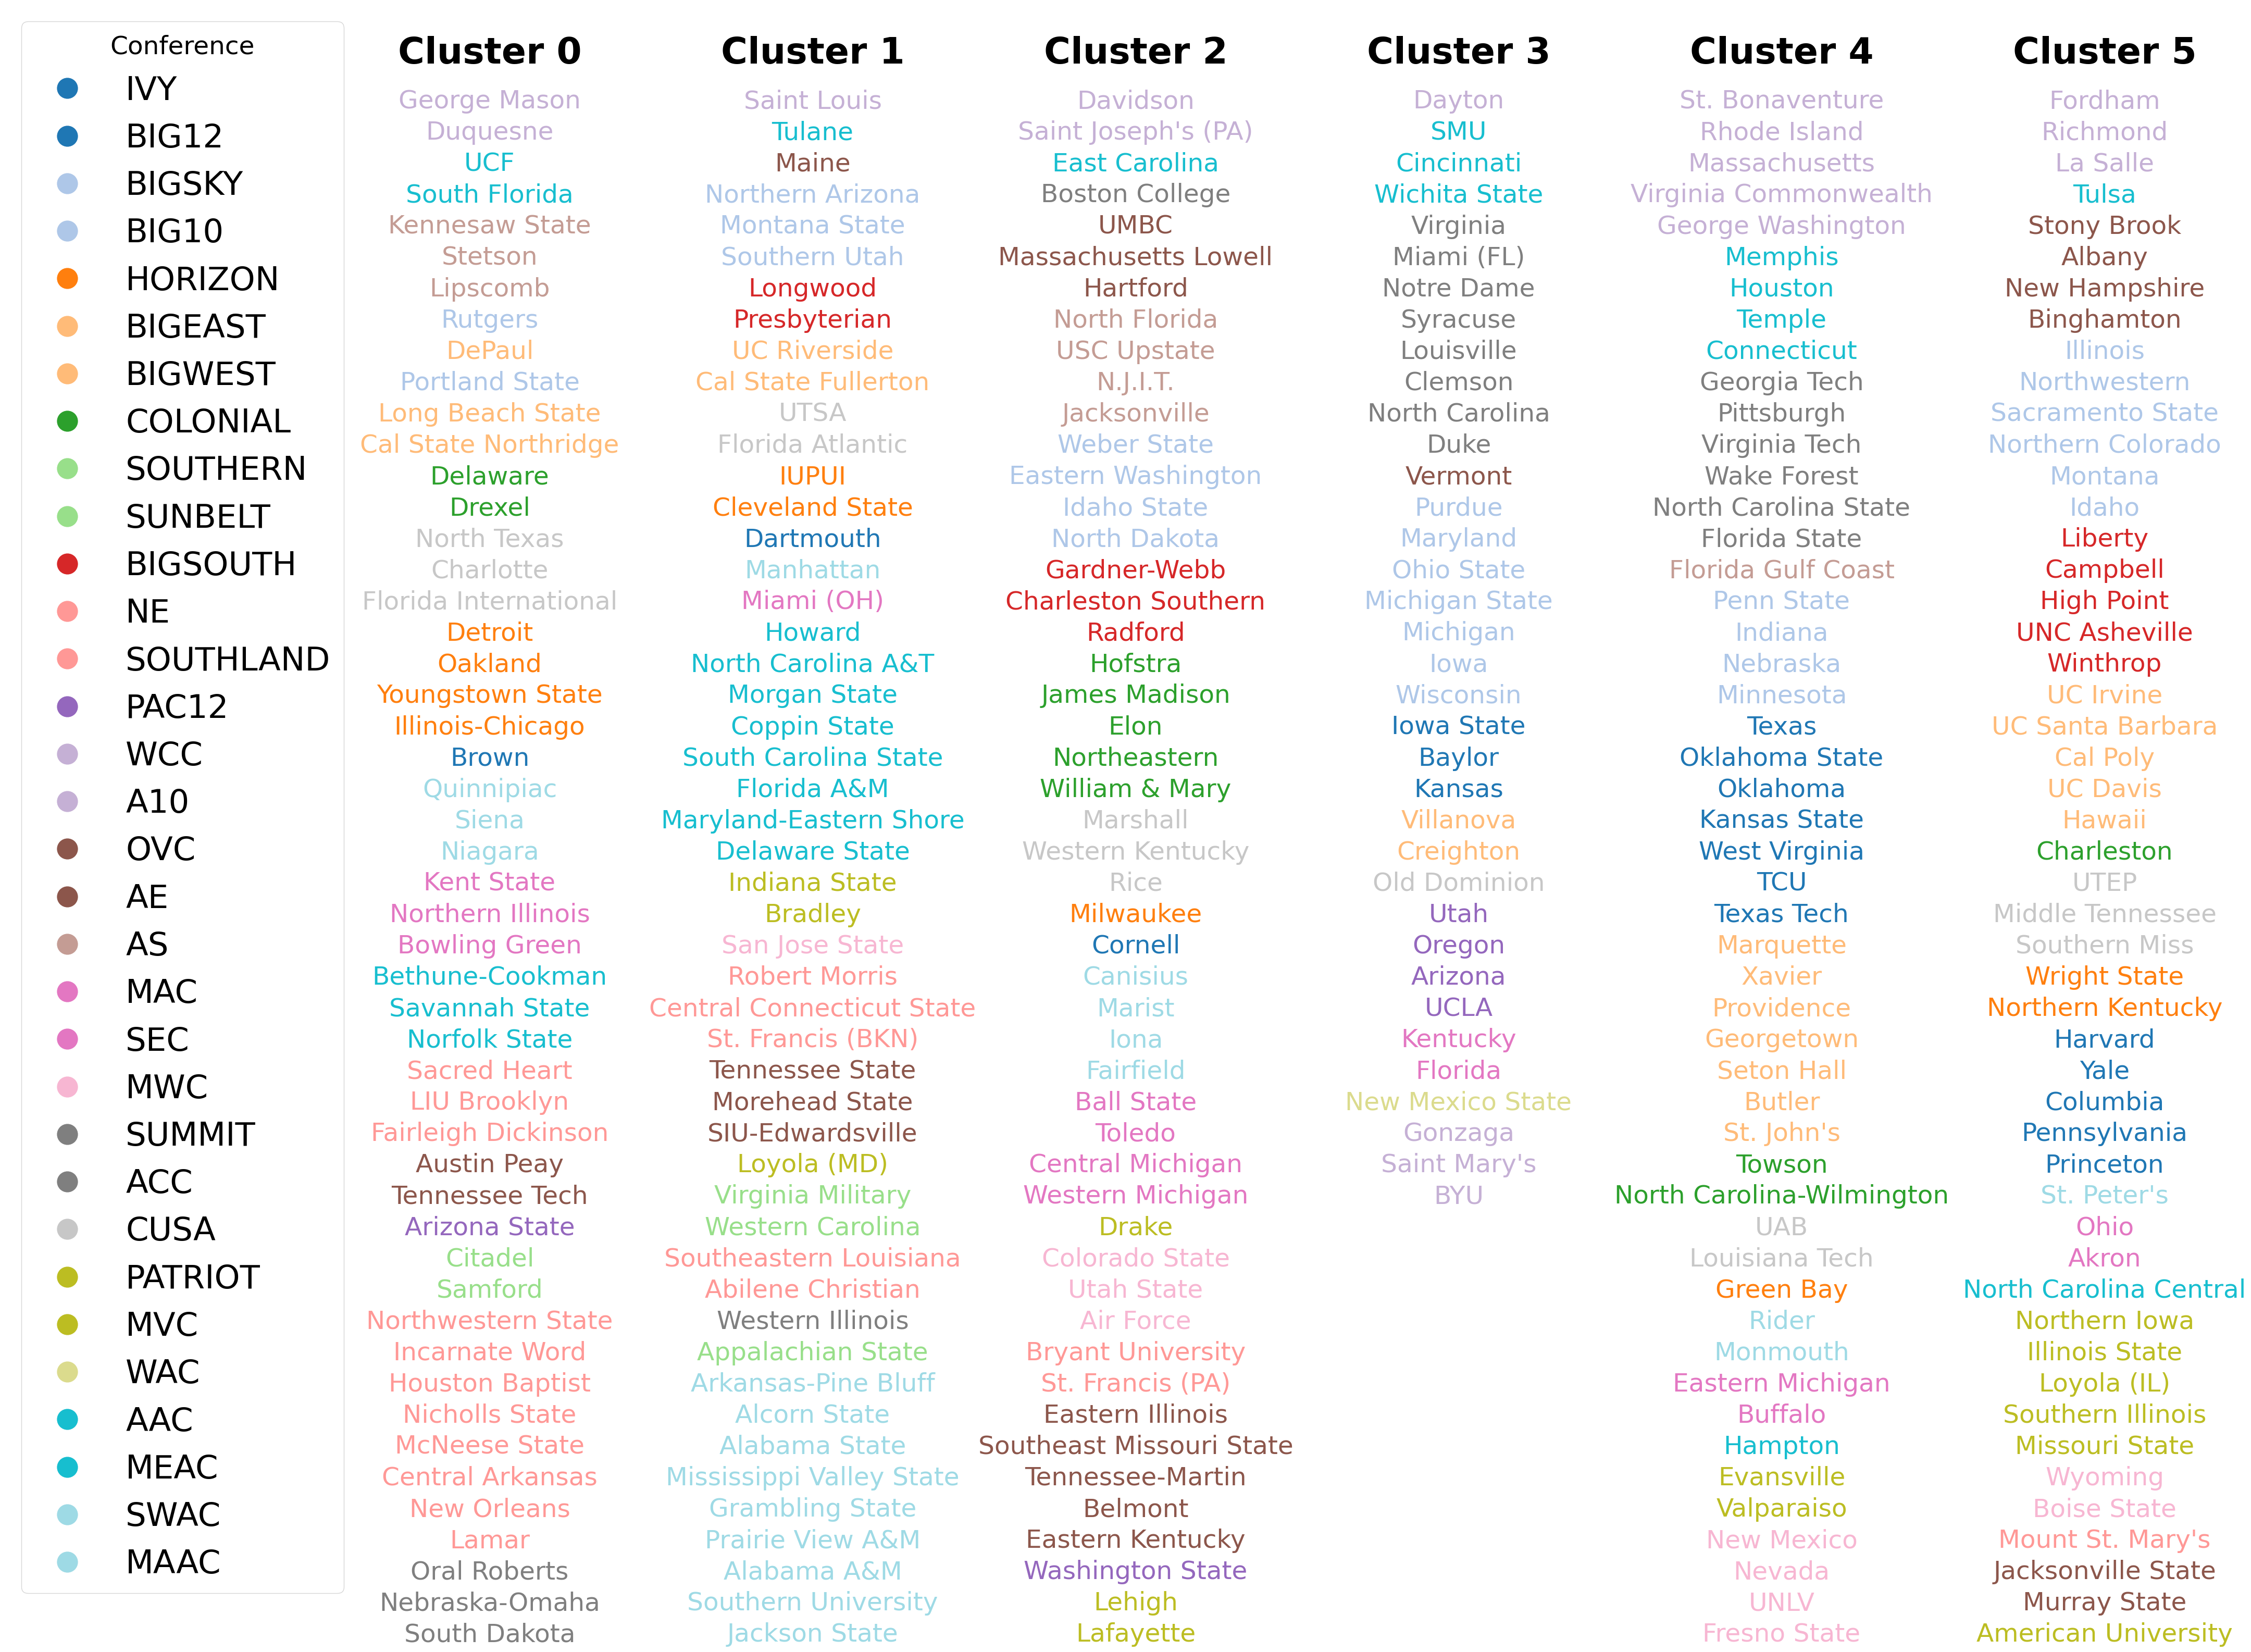

In [37]:
# print teams in each cluster from class clustering
cluster_teams = findTeamsFromClusters(dfTeamStats, 'class_cluster')
chartTeamClusters({key: value for key, value in cluster_teams.items() if key < 7})

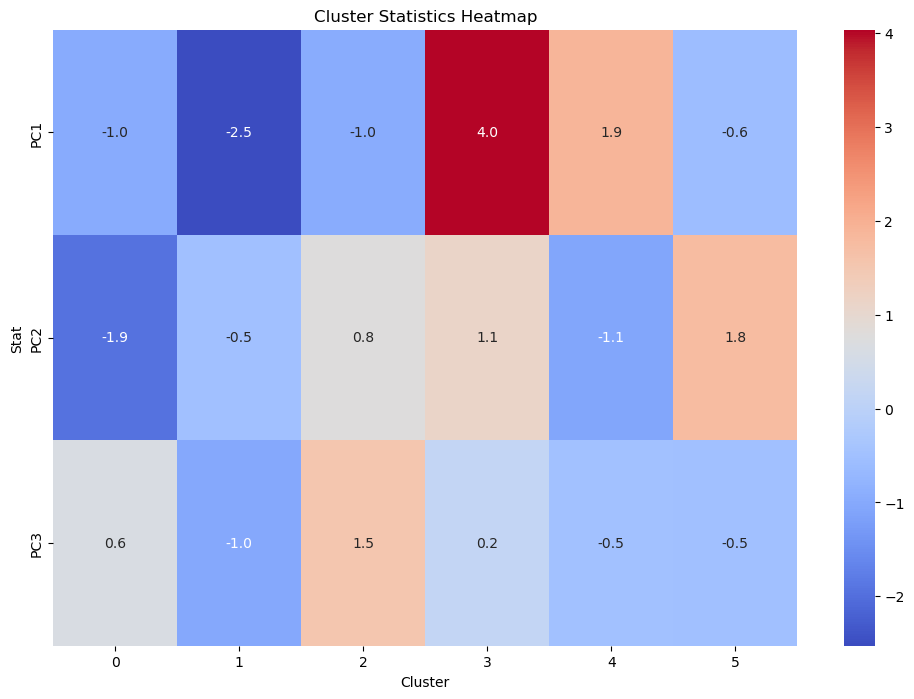

In [38]:
dfAgg = graphClusterStats(results1, 'cluster')

In [39]:
ari = adjusted_rand_score(clusters, class_clusters)
nmi = normalized_mutual_info_score(clusters, class_clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.9655726210884114
Normalized Mutual Information: 0.9632443058279772


These scores show that the clustering done via the sklearn kmeans algorithm was almost exactly the same as that done via the in class kmeans algorithm.

### Page Rank of Clusters

Using a column stochastic matrix where $M_{ij}$ is set to $\frac{\textrm{# of times j loses to i}}{\textrm{# of times j plays against i}}$. The columns of the matrix are normalized after the column is filled so that it adds to one.

In [28]:
# Set up Mf, the column-stochastic matrix
Mf = np.zeros((k, k), dtype=float)
for cluster_lose in range(k):
    for cluster_win in range(k):
        losses = len(dfTeamBox[(dfTeamBox['team_id'].isin(cluster_team_ids[cluster_win])) & (dfTeamBox['opp_id'].isin(cluster_team_ids[cluster_lose])) & (dfTeamBox['win'] == True)])
        total_games_between = len(dfTeamBox[(dfTeamBox['team_id'].isin(cluster_team_ids[cluster_win])) & (dfTeamBox['opp_id'].isin(cluster_team_ids[cluster_lose]))])
        Mf[cluster_win][cluster_lose] = losses / total_games_between
    colSum = np.sum(Mf[:,cluster_lose])
    if (colSum != 0):  
        Mf[:,cluster_lose] /= colSum

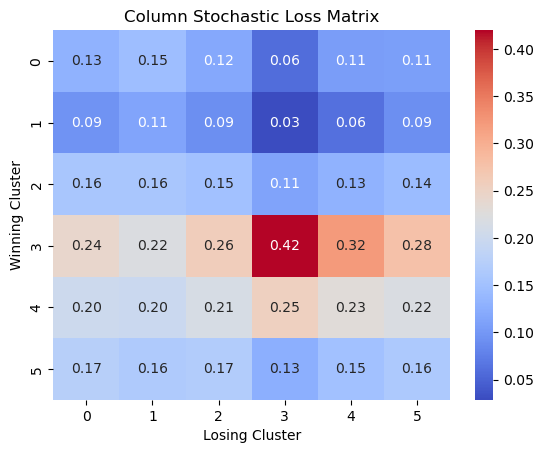

In [50]:
# plot Mf using a heatmap
sns.heatmap(Mf, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel('Losing Cluster')
plt.ylabel('Winning Cluster')
plt.title('Column Stochastic Loss Matrix')
plt.show()

In [73]:
# run page rank using a beta value of 0.85
beta = 0.85
Nmat = np.ones((k,k))/k
M1 = beta*Mf + (1-beta)*Nmat
r_old = np.repeat(1/k, k)

# pagerank matmul approach
for _ in range(10):
    r_new = np.matmul(M1, r_old)
    r_old = r_new

In [74]:
# print page rank results
sortrank=np.flip(np.argsort(r_new), axis=0)
sortrank
for i in sortrank:
    print(f'{i}: {r_new[i]}')

3: 0.2950198978020072
4: 0.21802288149204074
5: 0.15377956248849506
2: 0.13997075923546073
0: 0.10996509015264644
1: 0.08324180882934942


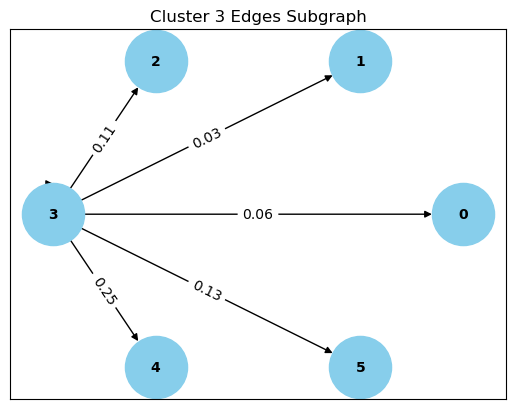

In [32]:
# print an example of what a subset of the page rank graph looks like
G = nx.DiGraph()
G.add_nodes_from(range(6))
weights = Mf

# add directed edges on the graph with weights
for i in range(3,4):
    for j in range(6):
        G.add_edge(i, j, weight=weights[j][i])

# draw the graph
pos = nx.circular_layout(G) 
nx.draw_networkx(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
edge_labels = {(i, j): f'{weight["weight"]:.2f}' for i, j, weight in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Cluster 3 Edges Subgraph')
plt.show()
